Author: Peter Akioyamen  
Description: A modernized implementation of LeNet-5 using Tensorflow 2.0

In [156]:
def load_data(X_path, y_path):
    """
    Reads and loads the data stored at X_path and y_path into numpy arrays.

    Parameters
    ----------
    X_path : str
        A numpy array containing the features of each instance
    y_path : str
        A numpy array containing the labels of each instance

    Returns
    -------
    X : ndarray
        A numpy array containing the input data stored at X_path
    y : ndarray
        A numpy array containing the input labels stored at y_path
    """
    
    X = np.loadtxt(X_path, delimiter=",")
    y = np.loadtxt(y_path, delimiter=",")

    # Reshape images
    X = np.reshape(X, (X.shape[0], 28, 28, 1))

    # Verify shape of data
    print("Shape of Images Array:", X.shape)
    print("Shape of Images Labels Array:", y.shape)
    return X, y

def select_learning_rate(epoch):
    """
    Takes the current epoch as input and returns the correct
    learning rate based on the learning rate schedule.

    Parameters
    ----------
    epoch : int
        A numpy array containing the features of each instance

    Returns
    -------
    rate : float
        The new learning rate for the next set of epochs
    """
    
    rates = [0.0001, 0.00001]
    if epoch < 11 :
        return rates[0]
    else: 
        return rates[1]
    
def create_tensor(array, w_init, b_init):
    """
    Converts the dimensions of trainable tensorflow variables stored in 
    array to tensorflow variable tensors.

    Parameters
    ----------
    array : list, ndarray
        A list containing the dimentions of all filters, weights, and biases
        which need to be converted to tensorflow Variables
    w_init : tensorflow initializer
        A tensorflow initializer for the filters and weights of a neural network
    b_init : tensorflow initializer
        A tensorflow initializer for the bias terms of a neural network
        
    Returns
    -------
    list
        A numpy array containing the input data stored at X_path
    """
    
    return [tf.Variable(w_init(element, dtype=tf.float64),trainable=True) if len(element) > 1 
            else tf.Variable(b_init(element, dtype=tf.float64),trainable=True) for element in array]

def conv2d_layer(inputs, kernel, stride, pad, activation="tanh", bias=None):
    """
    Creates a 2D convolutional layer in a neural network. 

    Parameters
    ----------
    inputs : 4D tensor
        The input tensor to the convolutional layer
    kernel : tensorflow Variable
        A tensorflow Variable storing the values composing the filter
    stride : int or list, ndarray
        Denotes the stride to use for the kernel. If int, the stride is of uniform size,
        if list, must be of form [N, H, W, C]
    pad : str
        "SAME" if the resulting channels should be the same dimensions as the input,
        adds zeros to outer edges of the image to preserve size
        "VALID" if the resulting channels should be smaller than the input size,
        does not add zeros to outer edges
    activation : str
        A string denoting which activation function to use. "tanh" for scaled hyperbolic tangent,
        "sig" for sigmoid, "relu" for rectified linear unit
    bias : tensorflow Variable
        A tensorflow Variable containing bias terms for this layer
    
    Returns
    -------
    layer : 4D tensor
        A 4D tensor containing resultant computed values
    """
    
    layer = tf.nn.conv2d(inputs, filters=kernel, strides=stride, padding=pad)
    layer = layer + bias
    
    if activation == "tanh": 
        A = tf.constant(1.7159, dtype=tf.float64)
        layer = tf.multiply(A, tf.nn.tanh(layer))
    if activation == "sig":
        layer = tf.nn.sigmoid(layer)
    if activation == "relu":
        layer = tf.nn.relu(layer)
    
    return layer
    
def pool_layer(inputs, sub_sample, stride, pad, pool_type="avg", activation="tanh", bias=None):
    """
    Creates a 2D pooling layer in a neural network. 

    Parameters
    ----------
    inputs : 4D tensor
        The input tensor to the pooling layer
    sub_sample : list, ndarray
        The size of the sub_sample to use of form [N, H, W, C]
    stride : int or list, ndarray
        Denotes the stride to use for the kernel. If int, the stride is of uniform size,
        if list, must be of form [N, H, W, C]
    pad : str
        "SAME" if the resulting channels should be the same dimensions as the input,
        adds zeros to outer edges of the image to preserve size
        "VALID" if the resulting channels should be smaller than the input size,
        does not add zeros to outer edges    
    pool_type : str
        Either "avg", which uses an average pooling, or, "max", which uses maximum pooling
    activation : str
        A string denoting which activation function to use. "tanh" for scaled hyperbolic tangent,
        "sig" for sigmoid, "relu" for rectified linear unit
    bias : tensorflow Variable
        A tensorflow Variable containing bias terms for this layer
    
    Returns
    -------
    layer : 4D tensor
        A 4D tensor containing resultant computed values
    """
    
    if pool_type == "avg":
        layer = tf.nn.avg_pool2d(inputs, ksize=sub_sample, strides=stride, padding=pad)
    else:
        layer = tf.nn.max_pool2d(inputs, ksize=sub_sample, strides=stride, padding=pad)
        
    layer = layer + bias
    
    if activation == "tanh":
        A = tf.constant(1.7159, dtype=tf.float64)
        layer = tf.multiply(A, tf.nn.tanh(layer))
    if activation == "sig":
        layer = tf.nn.sigmoid(layer)
    if activation == "relu":
        layer = tf.nn.relu(layer)
    
    return layer

def dense_layer(inputs, weights, activation="tanh", bias=None):
    """
    Creates a fully connected layer in a neural network. 

    Parameters
    ----------
    inputs : 2D tensor
        The input tensor to the fully connected layer
    weights : tensorflow Variable
        A tensorflow Variable storing the values composing the weights
    activation : str
        A string denoting which activation function to use. "tanh" for scaled hyperbolic tangent,
        "sig" for sigmoid, "relu" for rectified linear unit, "soft" for softmax
    bias : tensorflow Variable
        A tensorflow Variable containing bias terms for this layer
    
    Returns
    -------
    layer : 2D tensor
        A 2D tensor containing resultant computed values
    """
    
    layer = tf.matmul(inputs, weights)
    layer = layer + bias

    if activation == "tanh":
        A = tf.constant(1.7159, dtype=tf.float64)
        layer = tf.multiply(A, tf.nn.tanh(layer))
    if activation == "sig":
        layer = tf.nn.sigmoid(layer)
    if activation == "relu":
        layer = tf.nn.relu(layer)
    if activation == "soft":
        layer = tf.nn.softmax(layer)

    return layer

def LeNet_5(X, weights, padding, pools):
    """
    Creates a convolutional neural network modelled after the LeNet-5 architecture. 

    Parameters
    ----------
    X : 4D tensor
        The tensor storing input data
    weights : tensorflow Variable
        A tensorflow Variable storing the values composing the weights
    activation : str
        A string denoting which activation function to use. "tanh" for scaled hyperbolic tangent,
        "sig" for sigmoid, "relu" for rectified linear unit, "soft" for softmax
    bias : tensorflow Variable
        A tensorflow Variable containing bias terms for this layer
    
    Returns
    -------
    y_hat : 2D tensor
        The output values or probabilities predicted by the network
    """
    
    # Layer 1 - Convolution Layer 
    bias_C1 = weights[0]
    C1 = conv2d_layer(X, kernel=weights[1], stride=[1,1,1,1], pad=padding[0], activation="relu", bias=bias_C1)

    # Layer 2 - Pooling Layer (Max Pooling)
    bias_S2 = weights[2] 
    S2 = pool_layer(C1, sub_sample=pools[0], stride=[1,2,2,1], pad=padding[1], 
                        pool_type="max", activation="relu", bias=bias_S2) 

    # Layer 3 - Convolution Layer 
    bias_C3 = weights[3]
    C3 = conv2d_layer(S2, kernel=weights[4], stride=[1,1,1,1], pad=padding[1], activation="relu", bias=bias_C3)

    # Layer 4 - Pooling Layer (Max Pooling)
    bias_S4 = weights[5] 
    S4 = pool_layer(C3, sub_sample=pools[0], stride=[1,2,2,1], pad=padding[1],
                        pool_type="max", activation="relu", bias=bias_S4) 

    # Layer 5 - Convolution Layer 
    bias_C5 = weights[6] 
    C5 = conv2d_layer(S4, kernel=weights[7], stride=[1,1,1,1], pad=padding[1], activation="relu", bias=bias_C5)
    C5 = tf.squeeze(C5, [1,2])

    # Layer 6 - Fully Connected Layer
    bias_F6 = weights[8]
    F6 = dense_layer(C5, weights[9], activation="relu", bias=bias_F6)
    
    # Layer 7 - Fully Connected Layer (Output)
    bias_F7 = weights[10]
    y_hat = dense_layer(F6, weights[11], activation="soft", bias=bias_F7)

    return y_hat

# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.utils import to_categorical

In [153]:
# Load MNIST training data from csv files
X_train_path = "./Data/mnist_train_images.csv"
y_train_path = "./Data/mnist_train_labels.csv"
print("Loading training data...")
X_train, y_train = load_data(X_train_path, y_train_path)

# Load MNIST testing data from csv files
X_test_path = "./Data/mnist_test_images.csv"
y_test_path = "./Data/mnist_test_labels.csv"
print("Loading testing data...")
X_test, y_test = load_data(X_test_path, y_test_path)

Shape of Images Array: (60000, 28, 28, 1)
Shape of Images Labels Array: (60000,)


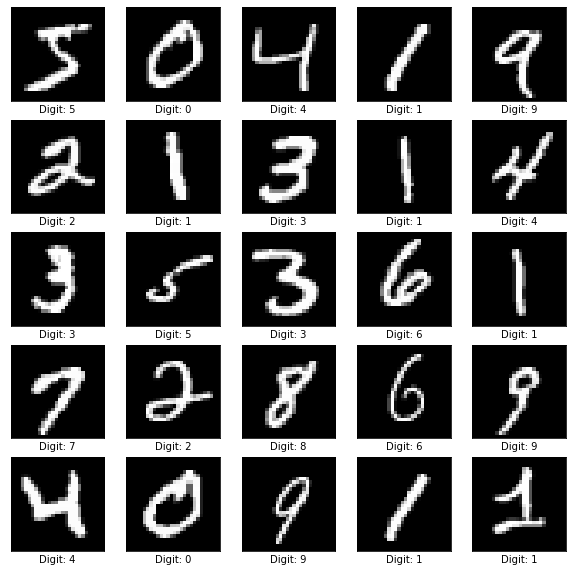

In [155]:
# Verify images loaded properly
# Visualize a set of digits with corresponding labels
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2]))[i], cmap=plt.cm.gray)
    plt.xlabel("Digit: " + str(int(y_train[i])))
plt.show()

In [171]:
# Instantiate the weight and bias initializers
w_initializer = tf.initializers.RandomNormal(mean=0.0, stddev=0.1)
b_initializer = tf.initializers.zeros()

# Define the dimensions of trainable variables including filters, weights, and bias terms
weights = [[6], [5, 5, 1, 6],
           [6],
           [16], [5, 5, 6, 16], 
           [16],
           [120], [5, 5, 16, 120],
           [84], [120, 84], 
           [10], [84, 10]]

# Define the padding algorithms to be used
padding = ["SAME", "VALID"]

# Define the size of the window used in the pooling layers
pools = [[1, 2, 2, 1]]

# Convert trainable variables to tensors
weights = create_tensor(weights, w_initializer, b_initializer)

# Define model hyperparameters
epochs = 20
batch_size = 32
lr_change = [10, 15]

In [172]:
# Instantiate the adam optimizer
optimizer = tf.optimizers.Adam()

# Define arrays to store the results from model
avg_loss_per_epoch = np.zeros(epochs)
avg_accy_per_epoch = np.zeros(epochs)
test_accy_per_epoch = np.zeros(epochs)

# Constant random order of training data
# Convert training data to tensors
train_inputs, train_targets = shuffle(X_train, y_train)
train_inputs = tf.cast(train_inputs, dtype=tf.float64) 
train_targets = tf.cast(to_categorical(train_targets, 10), dtype=tf.float64)

# Convert testing data to tensors
test_inputs = tf.cast(X_test, dtype=tf.float64)
test_targets = tf.cast(to_categorical(y_test, 10), dtype=tf.float64)

# Train convolutional neural network
for epoch in range(epochs):
    avg_loss = 0
    avg_accy = 0
    print("Epoch {}".format(epoch+1))
    print("--------")
    
    # Dynamic random order of training data
    #train_inputs, train_targets = shuffle(X_train, y_train)
    #train_inputs = tf.cast(train_inputs, dtype=tf.float64) 
    #train_targets = tf.cast(to_categorical(train_targets, 10), dtype=tf.float64)
    
    # Change the learning rate 
    if epoch in lr_change:
        optimizer.learning_rate = select_learning_rate(epoch)
    
    # Train on the batch for one epoch
    for next_batch in range(int(len(train_inputs) / batch_size)):
        with tf.GradientTape() as tape:
            # Get the next batch of training data
            images = train_inputs[(next_batch * batch_size):((next_batch + 1) * batch_size)]
            labels = train_targets[(next_batch * batch_size):((next_batch + 1) * batch_size)]
            
            # Compute predictions and average loss for the batch
            y_hat = LeNet_5(images, weights, padding, pools)
            loss = tf.reduce_mean(tf.losses.categorical_crossentropy(labels, y_hat, False))
                    
        # Record average accuracy for the batch
        accy = tf.reduce_mean(tf.metrics.categorical_accuracy(labels, y_hat))
        
        # Compute gradients and apply them to filters, weights, and biases of network
        gradients = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(gradients, weights))
        
        avg_loss += loss
        avg_accy += accy

        # Print results every 500 observations
        if (next_batch + 1) % 500 == 0:
            print("Loss: {:.04f} | Accuracy: {:.02f}%".format(avg_loss.numpy()/(next_batch + 1), avg_accy.numpy()*100/(next_batch + 1)))

    
    # Compute the validation accuracy on test data each epoch
    test_pred = LeNet_5(test_inputs, weights, padding, pools)
    test_accy = tf.reduce_mean(tf.metrics.categorical_accuracy(test_targets, test_pred))
    print("Test Accuracy: {:.02f}%\n".format(test_accy * 100))
    
    # Record average loss, average training accuracy, and test accuracy per epoch
    avg_loss_per_epoch[epoch] = avg_loss / (int(len(train_inputs) / batch_size))
    avg_accy_per_epoch[epoch] = (avg_accy * 100) / (int(len(train_inputs) / batch_size))
    test_accy_per_epoch[epoch] = test_accy * 100


Epoch 1
--------
Loss: 7.0298 | Accuracy: 53.73%
Loss: 3.6896 | Accuracy: 73.06%
Loss: 2.5213 | Accuracy: 80.24%
Test Accuracy: 95.99%

Epoch 2
--------
Loss: 0.1212 | Accuracy: 96.28%
Loss: 0.1111 | Accuracy: 96.70%
Loss: 0.1037 | Accuracy: 96.87%
Test Accuracy: 97.21%

Epoch 3
--------
Loss: 0.0831 | Accuracy: 97.38%
Loss: 0.0801 | Accuracy: 97.56%
Loss: 0.0753 | Accuracy: 97.69%
Test Accuracy: 97.02%

Epoch 4
--------
Loss: 0.0712 | Accuracy: 97.86%
Loss: 0.0647 | Accuracy: 98.06%
Loss: 0.0619 | Accuracy: 98.16%
Test Accuracy: 97.83%

Epoch 5
--------
Loss: 0.0574 | Accuracy: 98.28%
Loss: 0.0558 | Accuracy: 98.36%
Loss: 0.0547 | Accuracy: 98.38%
Test Accuracy: 97.78%

Epoch 6
--------
Loss: 0.0439 | Accuracy: 98.69%
Loss: 0.0467 | Accuracy: 98.66%
Loss: 0.0456 | Accuracy: 98.66%
Test Accuracy: 98.41%

Epoch 7
--------
Loss: 0.0398 | Accuracy: 98.70%
Loss: 0.0417 | Accuracy: 98.74%
Loss: 0.0414 | Accuracy: 98.78%
Test Accuracy: 98.44%

Epoch 8
--------
Loss: 0.0348 | Accuracy: 98.91%

Changes made  
Poolings are max instead of average  
Activations are relu instead of Atanh; only applied after convolution and dense layers (try w pooling layers too)  
Optimizer is Adam  
Learning rate is constant scheduled to decay at a different rate  
Batch size 32

In [178]:
w_initializer.get_config

<bound method RandomNormal.get_config of <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x000001F59036C988>>